# MAT 328 - Final Project
### Tony Lu

---

This project uses the [Motor Vehicle Collision](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95) dataset offered by [NYC Open Data](http://opendata.cityofnewyork.us/).

All data and values are dated March 2021 - the most recent date this notebook was executed. Executing this notebook at a later date may yield different results compared to what is already rendered in this notebook.

# Project Setup

### Import the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_theme(style='darkgrid')

### Download and load the data

In [ ]:
# This might take awhile. It has 1.7 million rows after all.
raw_data = pd.read_csv('https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df = raw_data.copy()

### Show the data

In [ ]:
df.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,03/05/2020,20:30,MANHATTAN,10018,40.755730,-73.990906,"(40.75573, -73.990906)",NaN,NaN,611 8 AVENUE,1.0,0.0,0,0,1,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4299462,E-Scooter,NaN,NaN,NaN,NaN
1,03/07/2020,19:13,BROOKLYN,11203,40.655823,-73.929825,"(40.655823, -73.929825)",NaN,NaN,256 EAST 51 STREET,0.0,0.0,0,0,0,0,0,0,Backing Unsafely,Unspecified,NaN,NaN,NaN,4305819,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
2,05/02/2020,14:00,MANHATTAN,10001,40.745697,-73.994510,"(40.745697, -73.99451)",NaN,NaN,270 7 AVENUE,1.0,0.0,0,0,1,0,0,0,Pedestrian/Bicyclist/Other Pedestrian Error/Co...,Unspecified,NaN,NaN,NaN,4311485,Bike,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
3,03/11/2020,17:22,NaN,NaN,40.633120,-74.136760,"(40.63312, -74.13676)",NaN,NaN,357 PORT RICHMOND AVENUE,0.0,0.0,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4299816,Sedan,NaN,NaN,NaN,NaN
4,04/03/2020,16:25,BROOKLYN,11236,40.633022,-73.906746,"(40.633022, -73.906746)",NaN,NaN,1132 EAST 83 STREET,0.0,0.0,0,0,0,0,0,0,Unsafe Speed,Unspecified,Unspecified,Unspecified,NaN,4308309,Sedan,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,Sedan,NaN


In [ ]:
# Show size of the data
print(f'Rows: {df.shape[0]} | Columns: {df.shape[1]}')

Rows: 1760597 | Columns: 29


In [ ]:
df.describe(include='all')

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
count,1760597,1760597,1219887,1219676.0,1.551949e+06,1.551949e+06,1551949,1405864,1141847,262365,1.760579e+06,1.760566e+06,1.760597e+06,1.760597e+06,1.760597e+06,1.760597e+06,1.760597e+06,1.760597e+06,1755646,1511494,117888,25344,6621,1.760597e+06,1751337,1469595,114698,24632,6447
unique,3171,1440,5,422.0,NaN,NaN,228291,12099,18871,160632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,61,50,39,29,NaN,1200,1293,184,74,53
top,01/21/2014,16:00,BROOKLYN,11207.0,NaN,NaN,"(0.0, 0.0)",BROADWAY,3 AVENUE,772 EDGEWATER ROAD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,NaN,Sedan,PASSENGER VEHICLE,Sedan,Sedan,Sedan
freq,1161,25452,382270,15498.0,NaN,NaN,1280,17203,9843,402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,630647,1270825,109698,23892,6235,NaN,429851,318607,30593,7047,1905
mean,NaN,NaN,NaN,NaN,4.069058e+01,-7.386787e+01,NaN,NaN,NaN,NaN,2.727404e-01,1.258118e-03,5.147515e-02,6.622754e-04,2.281385e-02,9.542218e-05,1.982867e-01,4.992625e-04,NaN,NaN,NaN,NaN,NaN,2.910184e+06,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,1.171749e+00,2.374386e+00,NaN,NaN,NaN,NaN,6.680392e-01,3.751831e-02,2.334128e-01,2.627235e-02,1.509028e-01,9.825940e-03,6.297944e-01,2.445084e-02,NaN,NaN,NaN,NaN,NaN,1.502974e+06,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000e+00,-2.013600e+02,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,2.200000e+01,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,4.066861e+01,-7.397605e+01,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,2.867247e+06,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,4.072216e+01,-7.392844e+01,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,3.516456e+06,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,4.076881e+01,-7.386667e+01,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,3.956843e+06,NaN,NaN,NaN,NaN,NaN


### Data Handling
- Clean up unneeded data
- Make sure the correct dtypes are being used
- Handle missing data

#### Unneeded data

In [ ]:
# We don't need COLLISION_ID as its more of a unique identifier for internal use
# LOCATION is just a combination of LONGITUDE and LATITUDE, having either is fine
df.drop(['COLLISION_ID', 'LOCATION'], axis=1, inplace=True)

#### Check and handle missing values

In [ ]:
# Check which columns have missing values
nulls = df.isnull().sum()
nulls[nulls > 0]

BOROUGH                           540710
ZIP CODE                          540921
LATITUDE                          208648
LONGITUDE                         208648
ON STREET NAME                    354733
CROSS STREET NAME                 618750
OFF STREET NAME                  1498232
NUMBER OF PERSONS INJURED             18
NUMBER OF PERSONS KILLED              31
CONTRIBUTING FACTOR VEHICLE 1       4951
CONTRIBUTING FACTOR VEHICLE 2     249103
CONTRIBUTING FACTOR VEHICLE 3    1642709
CONTRIBUTING FACTOR VEHICLE 4    1735253
CONTRIBUTING FACTOR VEHICLE 5    1753976
VEHICLE TYPE CODE 1                 9260
VEHICLE TYPE CODE 2               291002
VEHICLE TYPE CODE 3              1645899
VEHICLE TYPE CODE 4              1735965
VEHICLE TYPE CODE 5              1754150
dtype: int64

`CONTRIBUTING FACTOR VEHICLE` and `VEHICLE TYPE CODE` are used to identify the vehicle involved in the collision as well as the vehicle's role in the collision. 

`CONTRIBUTING FACTOR VEHICLE` and `VEHICLE TYPE CODE` can be kept as null. For a particular collision with 2 vehicles, The data should include information for these two vehicles but vehicles 3, 4, and 5 should be empty - it would make sense that values are missing from these columns.

In [ ]:
# Drop missing values
# OFF STREET NAME has too many missing values for us to take care of.
# With over 1.4 million missing values, it's over 80% of the data.
df.drop('OFF STREET NAME', axis=1, inplace=True)

# The data serves us no purpose if the geo-coordinates are missing.
# The coords can be used to retrieve info about borough, street, ZIP code
df.dropna(how='any', subset=['LATITUDE', 'LONGITUDE'], inplace=True)

In [ ]:
# Impute missing values

# For "NUMBER OF PERSONS INJURED" and "NUMBER OF PERSONS KILLED",
# There is only a small amount of values missing which makes it easy for us to impute it

# Impute "NUMBER OF PERSONS INJURED" via mean
injured_mean = df['NUMBER OF PERSONS INJURED'].mean()
df['NUMBER OF PERSONS INJURED'].replace(np.nan, injured_mean, inplace=True)

# Impute "NUMBER OF PERSONS KILLED" via mean
killed_mean = df['NUMBER OF PERSONS KILLED'].mean()
df['NUMBER OF PERSONS KILLED'].replace(np.nan, killed_mean, inplace=True)

The next few columns to worry about are `ZIP CODE`, `BOROUGH`, and `ON STREET NAME`. If we check the number of records with values missing in any of the 3 columns, we will see that there is about 600,000 values missing in total. Or about 35% of the total data - which is a big chunk of the total data but not enough to leave a huge impact if we drop them. By dropping them, we'll still have about 1 million left.

In [ ]:
filter = df[['ZIP CODE', 'BOROUGH', 'ON STREET NAME']].isnull().any(1)
df[filter].shape

(590134, 26)

In [ ]:
df.dropna(how='any', subset=['ZIP CODE', 'BOROUGH', 'ON STREET NAME'], inplace=True)
df.shape

(961815, 26)

#### Check dtypes

In [ ]:
df.dtypes

CRASH DATE                        object
CRASH TIME                        object
BOROUGH                           object
ZIP CODE                          object
LATITUDE                         float64
LONGITUDE                        float64
ON STREET NAME                    object
CROSS STREET NAME                 object
NUMBER OF PERSONS INJURED        float64
NUMBER OF PERSONS KILLED         float64
NUMBER OF PEDESTRIANS INJURED      int64
NUMBER OF PEDESTRIANS KILLED       int64
NUMBER OF CYCLIST INJURED          int64
NUMBER OF CYCLIST KILLED           int64
NUMBER OF MOTORIST INJURED         int64
NUMBER OF MOTORIST KILLED          int64
CONTRIBUTING FACTOR VEHICLE 1     object
CONTRIBUTING FACTOR VEHICLE 2     object
CONTRIBUTING FACTOR VEHICLE 3     object
CONTRIBUTING FACTOR VEHICLE 4     object
CONTRIBUTING FACTOR VEHICLE 5     object
VEHICLE TYPE CODE 1               object
VEHICLE TYPE CODE 2               object
VEHICLE TYPE CODE 3               object
VEHICLE TYPE COD

In [ ]:
# Fix the dtypes

df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'])

# These should be ints, not floats - can't have half a person dead
df['NUMBER OF PERSONS INJURED'] = df['NUMBER OF PERSONS INJURED'].astype(int)
df['NUMBER OF PERSONS KILLED'] = df['NUMBER OF PERSONS KILLED'].astype(int)

#### Miscellaneous Cleanup

In [ ]:
# Convert everything to uppercase to be consistent
# This might take a few seconds or minutes depending on system
# Took about ~10 seconds via Google Colab
df = df.applymap(lambda s:s.upper() if type(s) == str else s)
df.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
7,2020-04-16,2021-03-14 12:55:00,QUEENS,11101,40.753265,-73.94668,QUEENS PLAZA SOUTH,11 STREET,0,0,0,0,0,0,0,0,DRIVER INATTENTION/DISTRACTION,DRIVER INATTENTION/DISTRACTION,NaN,NaN,NaN,SEDAN,PICK-UP TRUCK,NaN,NaN,NaN
12,2020-04-22,2021-03-14 18:33:00,BROOKLYN,11218,40.635983,-73.97411,DITMAS AVENUE,EAST 5 STREET,1,0,0,0,0,0,1,0,UNSPECIFIED,UNSPECIFIED,NaN,NaN,NaN,SEDAN,SEDAN,NaN,NaN,NaN
13,2020-03-12,2021-03-14 20:50:00,QUEENS,11368,40.758305,-73.85561,NORTHERN BOULEVARD,114 STREET,0,0,0,0,0,0,0,0,VIEW OBSTRUCTED/LIMITED,UNSPECIFIED,NaN,NaN,NaN,STATION WAGON/SPORT UTILITY VEHICLE,STATION WAGON/SPORT UTILITY VEHICLE,NaN,NaN,NaN
18,2020-05-13,2021-03-14 21:25:00,QUEENS,11421,40.686447,-73.85485,ATLANTIC AVENUE,87 STREET,1,0,0,0,1,0,0,0,FAILURE TO YIELD RIGHT-OF-WAY,UNSPECIFIED,NaN,NaN,NaN,STATION WAGON/SPORT UTILITY VEHICLE,BIKE,NaN,NaN,NaN
19,2020-05-15,2021-03-14 15:00:00,BRONX,10456,40.829140,-73.90811,GOUVERNEUR PLACE,WASHINGTON AVENUE,0,0,0,0,0,0,0,0,UNSPECIFIED,NaN,NaN,NaN,NaN,SEDAN,NaN,NaN,NaN,NaN


# Explore the Data

Now that our data is formatted and a bit cleaned up, let's see what it can tell us.

Here we have a few questions the data might help answer:
- When and where do collisions occur?
- Who's involved?
- What's the most common reason behind a collision?
- Could a particular vehicle be the cause of most collisions?
- Are there hotspots that may cause more collisions/deaths?

## Single Variable Plots

#### Collisions by Region

With Manhattan being such a hotspot for NYC residents and tourists, one might believe Manhattan would have the most collisions. But in the following chart, we can see that isn't true. Brooklyn leads the all-time collision count at about 300,000 and Queens follows closely at a little over 250,000.

Text(0, 0.5, 'Total Collisions')

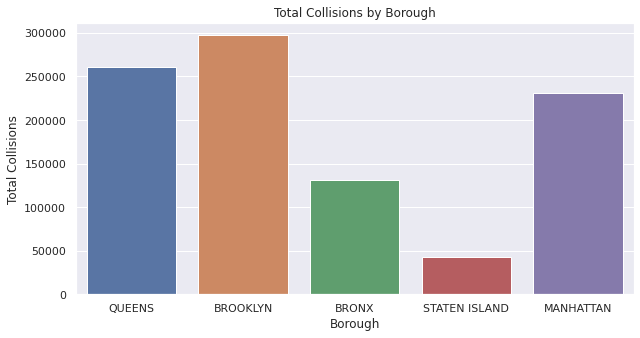

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.countplot(data=df, x='BOROUGH')
plt.title('Total Collisions by Borough')
plt.xlabel('Borough')
plt.ylabel('Total Collisions')

#### Collisions Over Time

Another good metric to explore is time. In the following graph, we can see the total collision reports per month, spanning from the data's inception of 2012.

Now that we're looking at the monthly collisions, we'll notice that all the years collectively have a relatively low amount of collision reports in the first half of the year, especially the month of April. However, interestingly, as the summer begins to approach, the number of collisions start to drastically increase and plateau until the year ends.

Text(0, 0.5, 'Total Collisions')

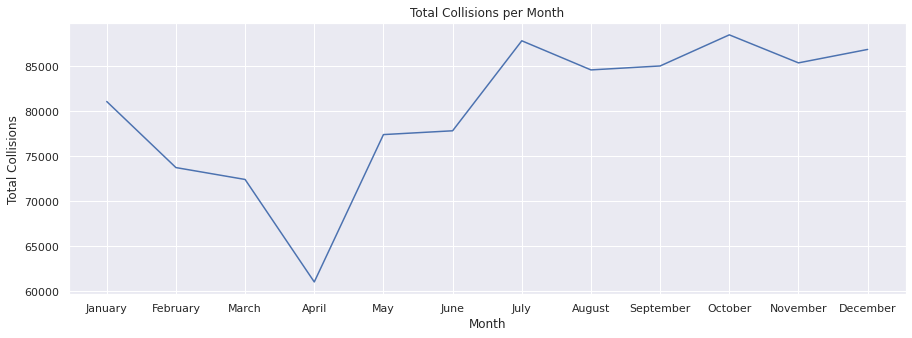

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

# Extract the month from all collisions
df_monthly = df['CRASH DATE'].dt.month_name().value_counts().to_frame('total')

# Re-order the rows by month
months_inorder = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_monthly = df_monthly.reindex(months_inorder, axis=0)

# Display it
sns.lineplot(data=df_monthly, x=df_monthly.index, y='total')
plt.title('Total Collisions per Month')
plt.xlabel('Month')
plt.ylabel('Total Collisions')

#### Persons Involved

Paying attention to the road is likely the most important aspect to master for anyone piloting a vehicle as lack of experience here can cause fatal consequences - like the victims reported in these collisions. But that skill doesn't apply only to the drivers but the pedestrians as well.

In the following, we will be looking at the people involved during collisions. How many are injured? How many suffered a lethal consequence?

Text(0, 0.5, 'Count')

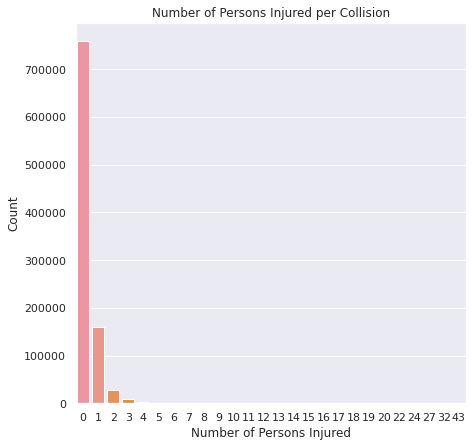

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

sns.countplot(data=df, x='NUMBER OF PERSONS INJURED')
plt.title('Number of Persons Injured per Collision')
plt.xlabel('Number of Persons Injured')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

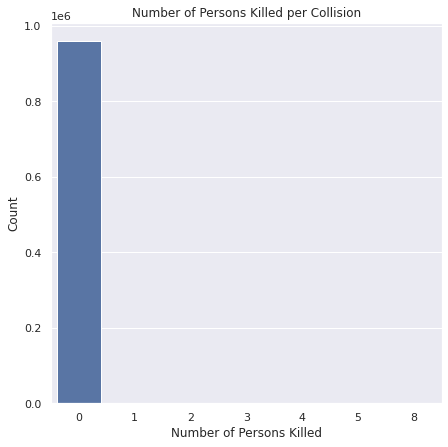

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

sns.countplot(data=df, x='NUMBER OF PERSONS KILLED')

plt.title('Number of Persons Killed per Collision')
plt.xlabel('Number of Persons Killed')
plt.ylabel('Count')

The above plots give us information on how many people are involved in the collisions and whether or not they suffered injuries and/or deaths. As it's noticeable, both plots have a large bar at zero which thankfully means a large portion of collisions involve no one being injured or dead. However, that doesn't mean it doesn't happen. In the plot representing individuals who were injured, we can see a couple hundred-thousand instances where one or more people are injured. As for the plot representing individuals who suffered fatality, the bars are not even visible due to "zero" being so large, almost reaching one million instances.

## Multivariable Plots

Now let's look at the relationships between multiple variables.

Text(0, 0.5, 'Number of Collisions')

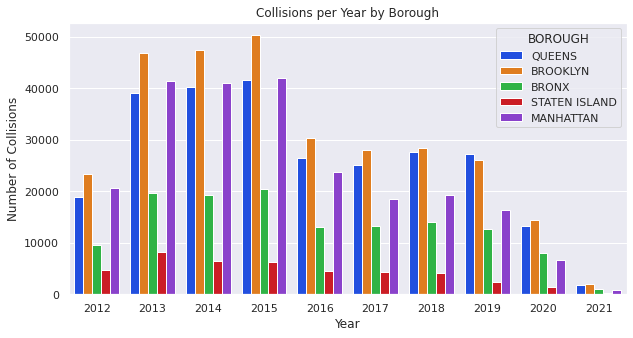

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.countplot(data=df, x=df['CRASH DATE'].dt.year, hue='BOROUGH', palette='bright')
plt.title('Collisions per Year by Borough')
plt.xlabel('Year')
plt.ylabel('Number of Collisions')

The figure above shows the number of collision reports per year in each borough. If we look at this closely, we’ll notice that each borough had a drastic increase in collisions starting from 2012 up until 2015. After that year, each borough began its overall decline in collisions. The decrease in collisions after 2015 might even be at the credit of the city government’s Vision Zero Campaign - a citywide initiative aimed to protect the public and reduce traffic accidents. 

Text(0, 0.5, 'Total Collisions')

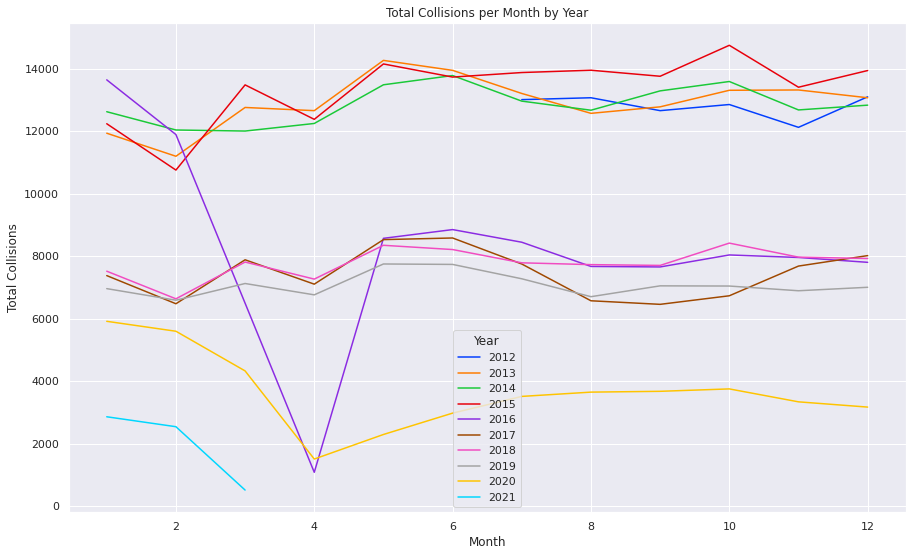

In [ ]:
month_year = pd.DataFrame()
month_year['CRASH YEAR'] = df['CRASH DATE'].dt.year
month_year['CRASH MONTH'] = df['CRASH DATE'].dt.month
month_year = month_year.value_counts().to_frame('TOTAL COLLISIONS').sort_index(ascending=True)

fig, ax = plt.subplots(figsize=(15, 9))
sns.lineplot(data=month_year, x='CRASH MONTH', y='TOTAL COLLISIONS', hue='CRASH YEAR', palette='bright')
plt.title('Total Collisions per Month by Year')
plt.legend(title='Year')
plt.xlabel('Month')
plt.ylabel('Total Collisions')

We found out earlier that Brooklyn was the leader amongst the 5 boroughs for the most collisions, let's take a look into that. In the following figure, we can see the top ten streets in Brooklyn with collisions. According to that plot, it seems Atlantic Ave, Flatbush Ave and Linden Boulevard are the most accident-prone areas of Brooklyn, with about 21,000 collisions since 2012 - that's roughly 2,600 collisions per year. Maybe it's a good idea to travel with caution the next time you enter these areas.

Sum of Top 3 Streets: 20970


Text(0, 0.5, 'Street Name')

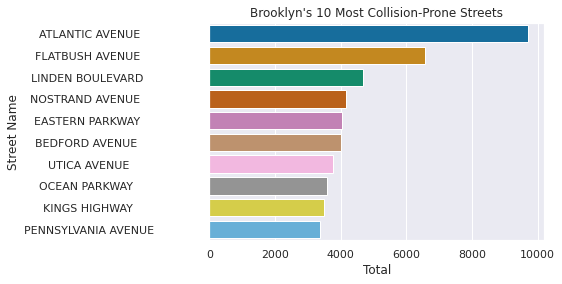

In [ ]:
brooklyndf = df[df['BOROUGH'] == 'BROOKLYN']

brooklyndf = brooklyndf['ON STREET NAME'].value_counts()[:10].to_frame('total').reset_index()
brooklyndf.rename(columns={'index': 'street'}, inplace=True)

print(f"Sum of Top 3 Streets: {brooklyndf['total'].loc[:2].sum()}")

sns.barplot(x='total', y='street', data=brooklyndf, palette='colorblind')
plt.title('Brooklyn\'s 10 Most Collision-Prone Streets')
plt.xlabel('Total')
plt.ylabel('Street Name')

If we look at the yearly collisions and how people are affected, the dataset shows injuries due to collisions have luckily decreased overall.

Text(0, 0.5, 'Number of Injured')

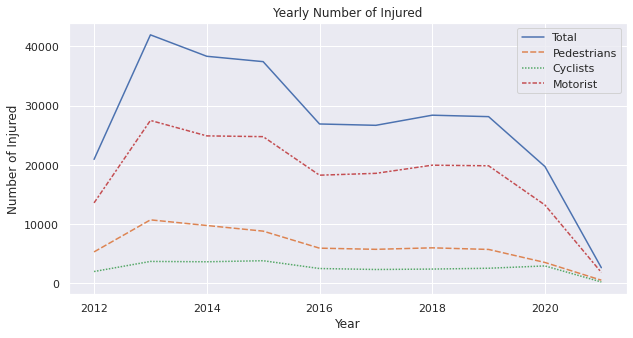

In [ ]:
injured_cols = ['CRASH DATE', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF MOTORIST INJURED']
yearly_injured_df = df[injured_cols]
yearly_injured_df = yearly_injured_df.groupby(yearly_injured_df['CRASH DATE'].dt.year).sum()

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=yearly_injured_df)
plt.legend(['Total', 'Pedestrians', 'Cyclists', 'Motorist'])
plt.title('Yearly Number of Injured')
plt.xlabel('Year')
plt.ylabel('Number of Injured')